## Starter code for TensorBoard
The following code shows how to use [TensorBoard](https://www.tensorflow.org/tensorboard) to display the results from an experiment comparing two learning curves. Please note, there are three ways to use TensorBoard. 
- You may install TensorBoard locally on your laptop
- You can run TensorBoard inside Colab (currently buggy)
- You can use TensorBoard.dev (this is the approach you should use for this assignment). 

In [0]:
%tensorflow_version 2.x

In [0]:
!pip install -U tensorboard

In [0]:
import tensorflow as tf

**Caution**. The following cell will delete any existing TensorBoard logs. If you're running this on your local machine, please be careful executing it.

In [0]:
!rm -rf ./tensorboard-logs/ # Clear any logs from previous runs

Import a dataset

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

### First style
The following code shows how to use TensorBoard with ```model.fit```.

In [0]:
from tensorflow.keras.layers import Dense, Flatten

def create_model():
  model = tf.keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='softmax'),
  ])
  return model

Create a logs directory

In [0]:
import datetime 
import os
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

Run an experiment.

The name of the experiment is given by the path of the logs directory (here, "exp1"). You'll want to use something more descriptive in your work (e.g., "swish-cifar-10").

In [0]:
from tensorflow.keras.optimizers import SGD

model = create_model() 
opt = SGD(learning_rate=0.001, momentum=0.0, nesterov=False) 
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

exp_dir = os.path.join(log_dir, "exp1")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tb_callback])

Run a second experiment.

Let's train another model, this time saving results to "exp2". Later, we'll be able to compare the learning curves of these experiments in TensorBoard.

In [0]:
model = create_model() 
opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

exp_dir = os.path.join(log_dir, "exp2")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tb_callback])

In [0]:
!tensorboard dev upload --logdir "$log_dir"

### Second style
Showing how to use TensorBoard with a Subclassed model and a GradientTape

Prepre the dataset

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = train_ds.shuffle(60000).batch(32)
test_ds = test_ds.batch(32)

Define a simple model

In [0]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten(input_shape=(28, 28))
    self.d1 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

model = MyModel()

In [0]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [0]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

Training and testing routines

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_fn(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

Prepare log writers (previously, these were handled by the callback)

In [0]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(log_dir, "test"))

Train and log summaries

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  
  for images, labels in train_ds:
    train_step(images, labels)
    
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  with train_writer.as_default():
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', train_loss.result(), step=epoch)

    # ====
    # Demo: show how to use histogram summaries
    # Create and log some random data
    # Useful if you're attemping the extra credit question
    # ====
    data = tf.random.normal((32, 100))
    tf.summary.histogram('random', 
                         data,
                         step=epoch, 
                         description='Your description')
    
  with test_writer.as_default():
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    
  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

In [0]:
!tensorboard dev upload --logdir "$log_dir"


## Run an experiment to see whether Swish is helpful on a small dataset

- Choose a small datasets (e.g., CIFAR-10). 
- Train two NNs: One using ReLu activation, and one using your Swish implementation. 
- Visualize the learning curves for training & validation loss and accuracy using TensorBoard.dev (you can find starter code for TensorBoard.dev at the bottom of this notebook). 
- Fix the TensorFlow random seed before running these experiments, so your results are reproducibile (you can find a notebook on CourseWorks that demonstrates how to fix the seed).

Note: It may be difficult to see whether Swish is helpful with a small experiment like this, and it's likely that your learning curves will be noisy. You do not need to run a perfect experiment (the goal is for you to gain experience implementing a custom activation function, and to learn how to use TensorBoard).


In [0]:
from keras import backend as K
import numpy as np

def swish_activation(x, beta=1):
  return x * K.sigmoid(beta*x)

In [0]:
import matplotlib.pyplot as plt

# Test the swish function
beta = 0.8
x = np.linspace(-5, 5, 100)
y = swish_activation(x, beta)

plt.figure()
plt.plot(x, y)

In [0]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

In [0]:
# TODO: your code here
# You may add additional code cells if helpful
# You can find example code for TensorBoard.dev at the bottom of this notebook
# Load the data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255
x_test = x_test / 255

In [0]:
# Set up Tensor Board
!pip install -U tensorboard
import tensorflow as tf
import datetime 
import os
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

In [0]:
from tensorflow import keras
exp_dir = os.path.join(log_dir, "relu")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

# Model 1: relu activation
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), input_shape=x_train[0].shape, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64, strides=(1, 1), kernel_size=(5, 5), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128, strides=(1, 1), kernel_size=(7, 7), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(keras.layers.Flatten())
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, activation="softmax"))  

# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                  restore_best_weights=True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=100, callbacks=[early_stopping_cb, tb_callback])

In [0]:
exp_dir = os.path.join(log_dir, "swish")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)
# Model 2: swish activation
beta = 1
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), input_shape=x_train[0].shape, padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation(swish_activation))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64, strides=(1, 1), kernel_size=(5, 5), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation(swish_activation))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128, strides=(1, 1), kernel_size=(7, 7), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation(swish_activation))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(keras.layers.Flatten())
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, activation="softmax"))  

# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                  restore_best_weights=True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=100, callbacks=[early_stopping_cb, tb_callback])

In [0]:
!tensorboard dev upload --logdir "$log_dir"


## Use LIME to visualize model

In [0]:
!pip install lime

In [0]:
import lime
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from lime import lime_image
from skimage.io import imread
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image

In [0]:
model = InceptionV3()

In [0]:
def preprocess_img(path_list):
  out = []
  for img_path in path_list:
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)
    out.append(x)
  return np.vstack(out)

Upload an image via the Colab UI, or download one via wget.

In [0]:
#!wget img_url -O img.jpg

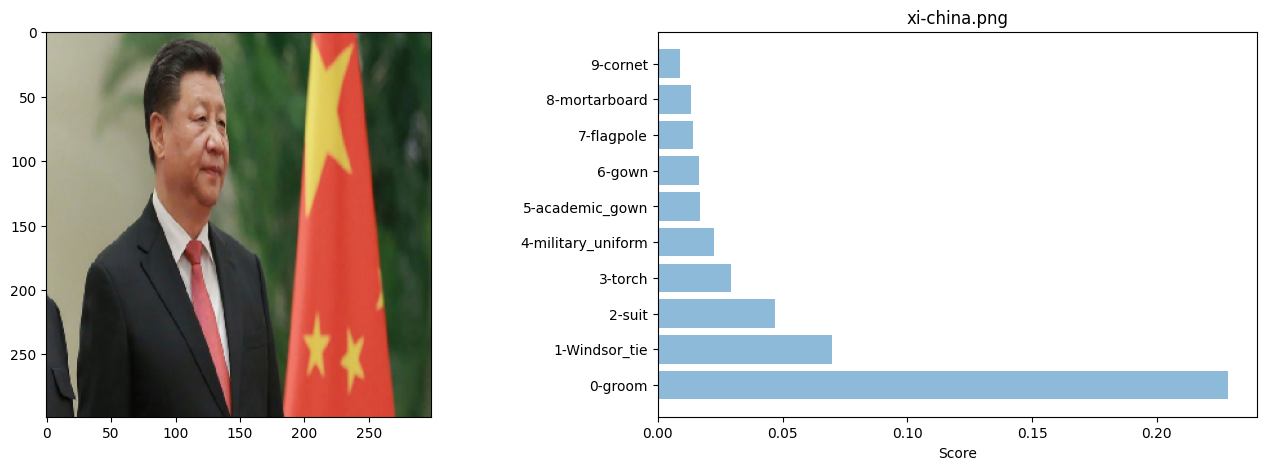

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

# Get the top 10 prediction
image_name = 'xi-china.png'
images = preprocess_img([image_name])
preds = model.predict(images)
objects = []
performance = []
for index, x in enumerate(decode_predictions(preds, top=10)[0]):
    objects.append(str(index) + '-' + x[1])
    performance.append(x[2])

# Plot the image and predictions
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)    
plt.imshow(images[0] / 2 + 0.5)

plt.subplot(1, 2, 2)
y_pos = np.arange(len(objects))
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Score')
plt.title(image_name)

plt.show()

In [0]:
explainer = lime_image.LimeImageExplainer()

In [0]:
%%time
explanation = explainer.explain_instance(images[0], model.predict, top_labels=len(objects), hide_color=0, num_samples=1000)

CPU times: user 14.7 s, sys: 1.54 s, total: 16.3 s
Wall time: 16 s


Text(0.5, 1.0, '3-torch')

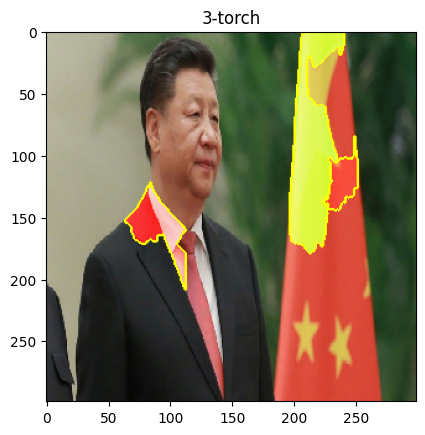

In [0]:
from skimage.segmentation import mark_boundaries
label_num = 3
temp, mask = explanation.get_image_and_mask(explanation.top_labels[label_num], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(objects[label_num])